# Maren Equations

Sergey and Lauren developed a set of equtions found here:

Nuzhdin, S. V, Friesen, M. L., & McIntyre, L. M. (2012). Genotype-phenotype mapping in a post-GWAS world. Trends in Genetics : TIG, 28(9), 421–6. doi:10.1016/j.tig.2012.06.003

which potentially allow for the identificqtion of *cis*- and *trans*-effects. Here I try using these qeustions and test if they give reasonable results.

Basics:
For a given gene the expression level of $E_{ii}$ of allele *i* in F1 genotype *i*. 

$E_{ii} = \mu + C_i + (T_i + T_t)/2$

$E_{ti} = \mu + C_t + (T_i + T_t)/2$

For each allele the *cis*- and *trans*-effects are deviations from the population means, we expect that they will sum to zero:

$\sum^n_{i=1}C_i = 0$

$\sum^n_{i=1}T_i = 0$

Then the expected difference in expression between the Line and Tester allele over the entire population is:

$\sum^n_{i=1} \frac{E_{ti} - E_{ii}}{n}$

Which can be re-written as

$\sum^n_{i=1} \frac{C_{t} - C_{i}}{n} = C_t$

The *cis*-effect of allele *i* can be estimated by:

$\hat C_i = \hat E_{ii} - \hat E_{ti} + \hat C_t$

The *trans*-effect of allele *t* can be estimated by:

$T_t = 2*(\sum(Eti)/n -\mu - C_t)$

However, $T_t$ and $C_t$ are confounded because their effects are present in all genotypes. This formulation will make it so that $C_t = -1 * T_t$. 

The *trans*-effect of allele *i* can be estimated by:

$T_i = 2*(E_{ti} - \mu - C_t) - T_t$

In [1]:
# Set-up default environment
%run '../ipython_startup.py'

# Import additional libraries
import sas7bdat as sas
import cPickle as pickle
import statsmodels.formula.api as smf

from ase_cisEq import marenEq
from ase_cisEq import marenPrintTable

from ase_normalization import meanCenter
from ase_normalization import q3Norm
from ase_normalization import meanStd

# Set Globals
SHAPES = {'M': 'o', 'V': '^'}
CMAP='jet'

Importing commonly used libraries: 
            os, sys 
            numpy as np 
            scipy as sp 
            pandas as pd 
            matplotlib as mp 
            matplotlib.pyplot as plt
            datetime as dt 
            mclib_Python/flagging as fg

Creating project level variables: 
        MCLAB = /home/jfear/mclab 
        PROJ = /home/jfear/mclab/cegs_ase_paper 
        TODAY = 20150928

Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH



In [2]:
# Two plotting helper functions to make panels that I need.

def getR2(df, x, y):
    """ Function to calculate the R-squared """
    # Intercept model
    formula = '{} ~ {} + 1'.format(y, x)
    return smf.ols(formula, df).fit().rsquared


def scatPlt(df, x, y, c=None, cmap='jet', s=50, marker='o', ax=None, title=None, xlab=None, ylab=None, diag='pos'):
    
    ax = df.plot(x, y, kind='scatter', ax=ax, c=c, cmap=cmap, s=s, marker=marker, title=title, colorbar=False)
    
    # Add a diag line
    if diag == 'neg':
        # draw a diag line with negative slope
        ax.plot([0, 1], [1, 0], transform=ax.transAxes)
    elif diag == 'pos':
        # draw a diag line with positive slope
        ax.plot([0, 1], [0, 1], transform=ax.transAxes)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
    return ax

def scatPltPanel(df, line='sum_line', tester='sum_tester', x='cis_line', y='prop', cmap='jet', s=60, panel_title=None, diag='pos'):
    
    # Plot the cis-line effects x proportion Line by fusion
    df['prop'] = 1 - df[tester] / (df[line] + df[tester])
    
    # Create 5x5 panel plot
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle(panel_title, fontsize=12, fontweight='bold')
    axes = axes.ravel()

    # Group by fusion_id
    for i, (n, gdf) in enumerate(df.groupby('fusion_id')):
        ax = axes[i]
                    
        # Calculate R-squared value
        r2 = getR2(gdf, x, y)

        # Make new title with R-squared in it
        t = '{}\nR^2: {}'.format(n, round(r2, 3))

        # Change marker style based on mating status and plot
        for ms, msdf in gdf.groupby('mating_status'):
            scatPlt(msdf, x, y, c='color', cmap=cmap, s=s, marker=SHAPES[ms], ax=ax, title=t, xlab=x, ylab=y, diag=diag)

        # only plot 25 fusions
        if i == 24:
            break
    
    return fig

## Import clean data set

This data set was created by: ase_summarize_ase_filters.sas

The data has had the following droped:
* regions that were always bias in 100 genome simulation
* regions with APN $\le 25$
* regions not in at least 10% of genotypes
* regions not in mated and virgin
* genotypes with extreme bias in median(q5_mean_theta)
* genotypes with $\le500$ regions

In [12]:
# Import clean dataset
with sas.SAS7BDAT(os.path.join(PROJ, 'sas_data/clean_ase_stack.sas7bdat')) as FH:
    df = FH.to_data_frame()
    
dfClean = df[['line', 'mating_status', 'fusion_id', 'flag_AI_combined', 'q5_mean_theta', 'sum_both', 'sum_line', 'sum_tester', 'sum_total', 'mean_apn']]
print 'Rows ' + str(dfClean.shape[0])
print 'Columns ' + str(dfClean.shape[1])
print 'Number of Genotypes ' + str(len(set(dfClean['line'].tolist())))
print 'Number of Exonic Regions ' + str(len(set(dfClean['fusion_id'].tolist())))

[clean_ase_stack.sas7bdat] header length 65536 != 8192
[clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] header length 65536 != 8192


Rows 159934
Columns 10
Number of Genotypes 49
Number of Exonic Regions 5391


### Additional cleaning
For the maren equations, I am also going to drop exonic regions with less than 10 genotypes. The maren equations make some assumptions about the population level sums. Obvisouly the more genotypes that are present for each fusions the better, but I am comfortable with as few as 10 genotypes.

In [13]:
# Drop groups with less than 10 lines per fusion
grp = dfClean.groupby(['mating_status', 'fusion_id'])
dfGt10 = grp.filter(lambda x: x['line'].count() >= 10).copy()
print 'Rows ' + str(dfGt10.shape[0])
print 'Columns ' + str(dfGt10.shape[1])
print 'Number of Genotypes ' + str(len(set(dfGt10['line'].tolist())))
print 'Number of Exonic Regions ' + str(len(set(dfGt10['fusion_id'].tolist())))

Rows 131700
Columns 10
Number of Genotypes 49
Number of Exonic Regions 3053


In [9]:
# To color by genotype I add a color column
colors = {}
cnt = 0
genos = set(dfGt10['line'].tolist())
for l in genos:
    colors[l] = cnt
    cnt += 1

dfGt10['color'] = dfGt10['line'].map(colors)

## Raw Counts

The equations are set up to subtract $\mu$, so I should be able to use raw counts. Again notice that the tester effects cannot be separated are therefore releated.

Running the Maren equations give me the following results for F10005_SI.

In [10]:
# Calculate Maren TIG equations by mating status and exonic region
marenRawCounts = marenEq(dfGt10, Eii='sum_line', Eti='sum_tester', group=['mating_status', 'fusion_id'])
marenRawCounts['mag_cis'] = abs(marenRawCounts['cis_line'])
marenPrintTable(marenRawCounts)

,,,flag_AI_combined,sum_both,sum_line,sum_tester,cis_line,cis_tester,trans_line,trans_tester,mean_apn
line,mating_status,fusion_id,,,,,,,,,
r101,M,F10005_SI,0,1274,155,133,28.666667,6.666667,-448.133333,-6.666667,29.523922
r280,M,F10005_SI,0,1208,126,143,-10.333333,6.666667,-428.133333,-6.666667,27.917307
r315,M,F10005_SI,0,1231,237,218,25.666667,6.666667,-278.133333,-6.666667,31.867690
r324,M,F10005_SI,1,2554,349,276,79.666667,6.666667,-162.133333,-6.666667,60.087419
r335,M,F10005_SI,0,1339,215,217,4.666667,6.666667,-280.133333,-6.666667,33.474306
r340,M,F10005_SI,1,1897,332,102,236.666667,6.666667,-510.133333,-6.666667,44.059067
r357,M,F10005_SI,1,2797,358,408,-43.333333,6.666667,101.866667,-6.666667,67.345540
r358,M,F10005_SI,0,1494,185,162,29.666667,6.666667,-390.133333,-6.666667,34.797401
r365,M,F10005_SI,0,2313,385,386,5.666667,6.666667,57.866667,-6.666667,58.291790


Now I plot the cis-line effects vs the proportion of line ($1 - \text{sum_tester}/(\text{sum_line} + \text{sum_tester})$) coloring by genotype. Virgin are traingles and mated are circles. I am plotting just the first 25 exonic regions. 

*cis*-line effects for some exonic regions (i.e., F10005_SI) are linearly related to he proportion of allele speicif reads. Unlinke ASE (y-axis), genotypes are mostly centered around 0 for the cis-effects (x-axis). 

There are cases where the *cis*-effects deviate from the proportion (e.g., two greenish dots in F10137_SI towards the right), but these are different genotypes (Mated). These could correspond to variations in coverage.

Interestingly, there are some exonic regions that have no linear trend (e.g., F10317_SI). This could indicate that *trans*-effects are more imortant for AI, or a technical bias.

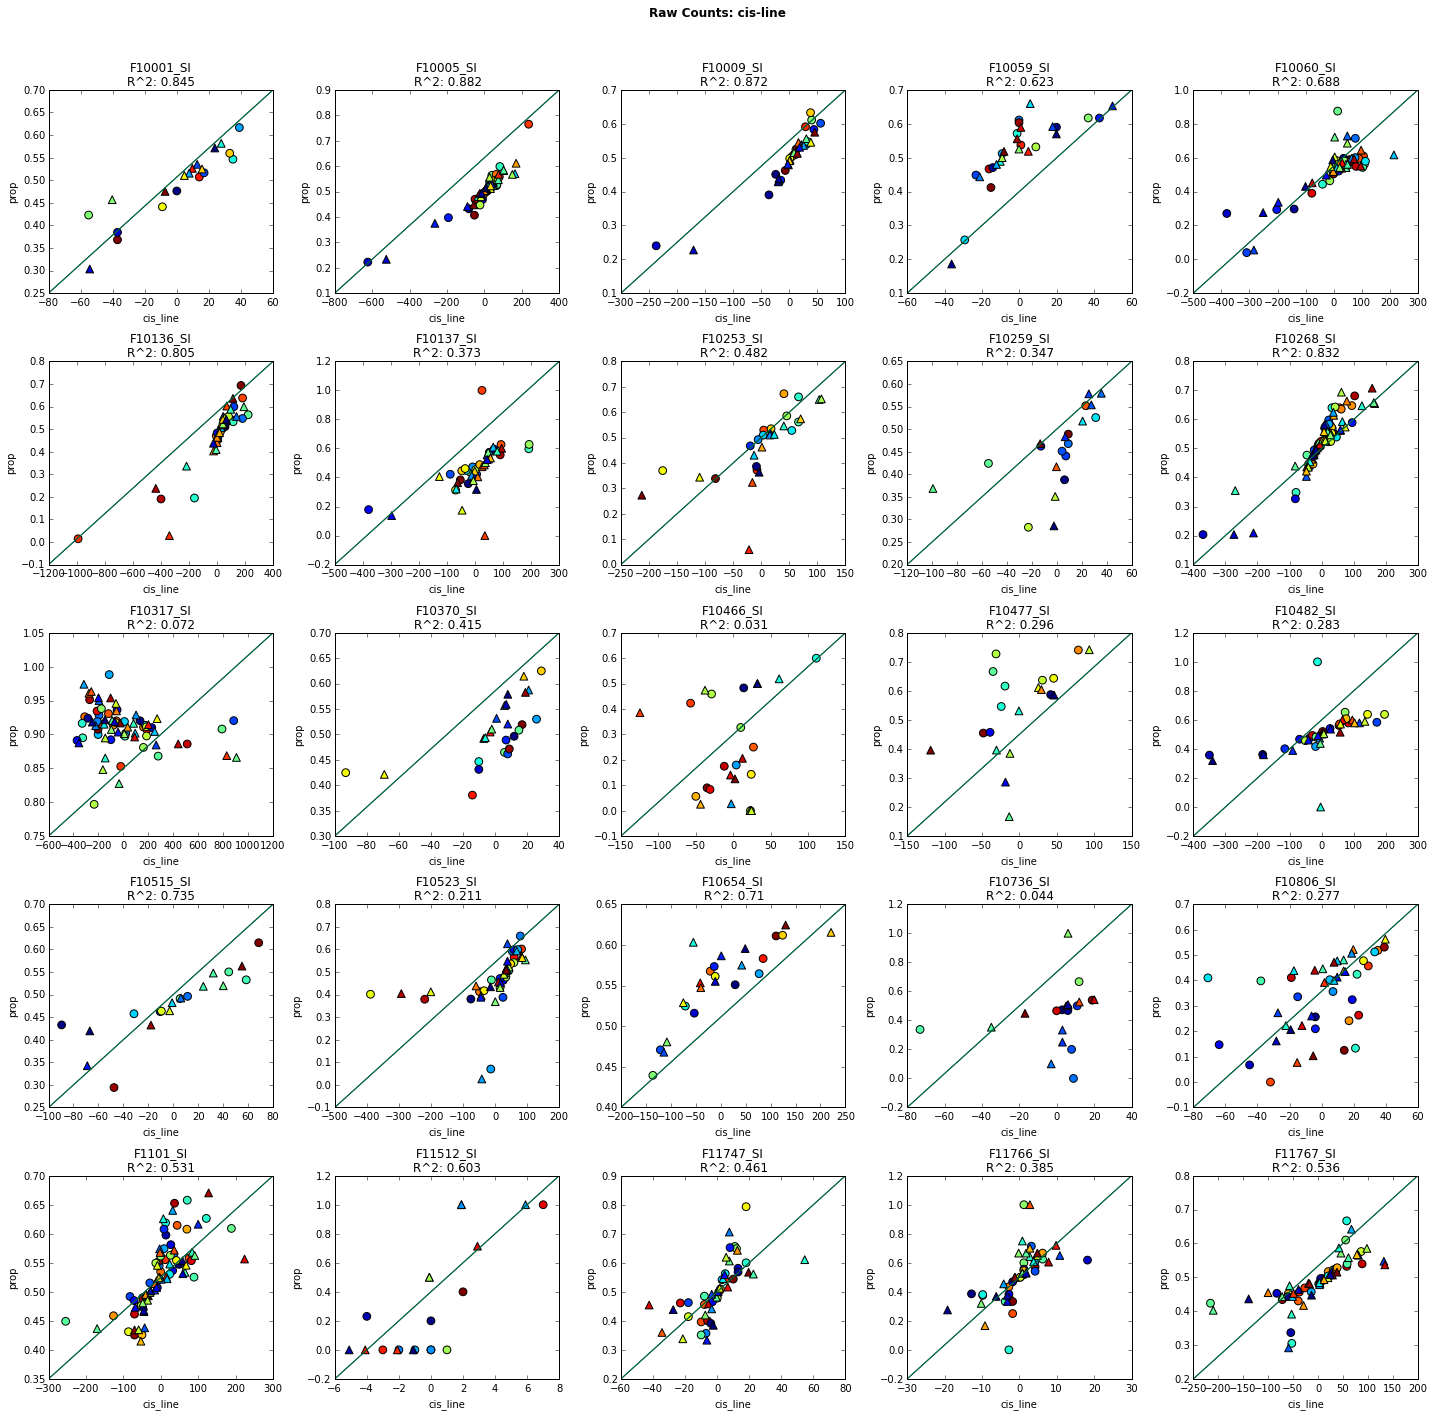

In [28]:
# Plot the cis-line effects x proportion by fusion
fig = scatPltPanel(marenRawCounts, line='sum_line', tester='sum_tester', cmap=CMAP, panel_title='Raw Counts: cis-line')
plt.tight_layout(rect=[0, 0, 1, .95])

Now I create the same plots as above, but using *trans*-line effects as my x-axis. Some of the *trans*-effects look negatively related. I think the two really interesting cases are 'F1017_SI' and 'F10482_SI'. Their cis-line effects are not linear, but both have a negative relationship in the *trans*-line effects.

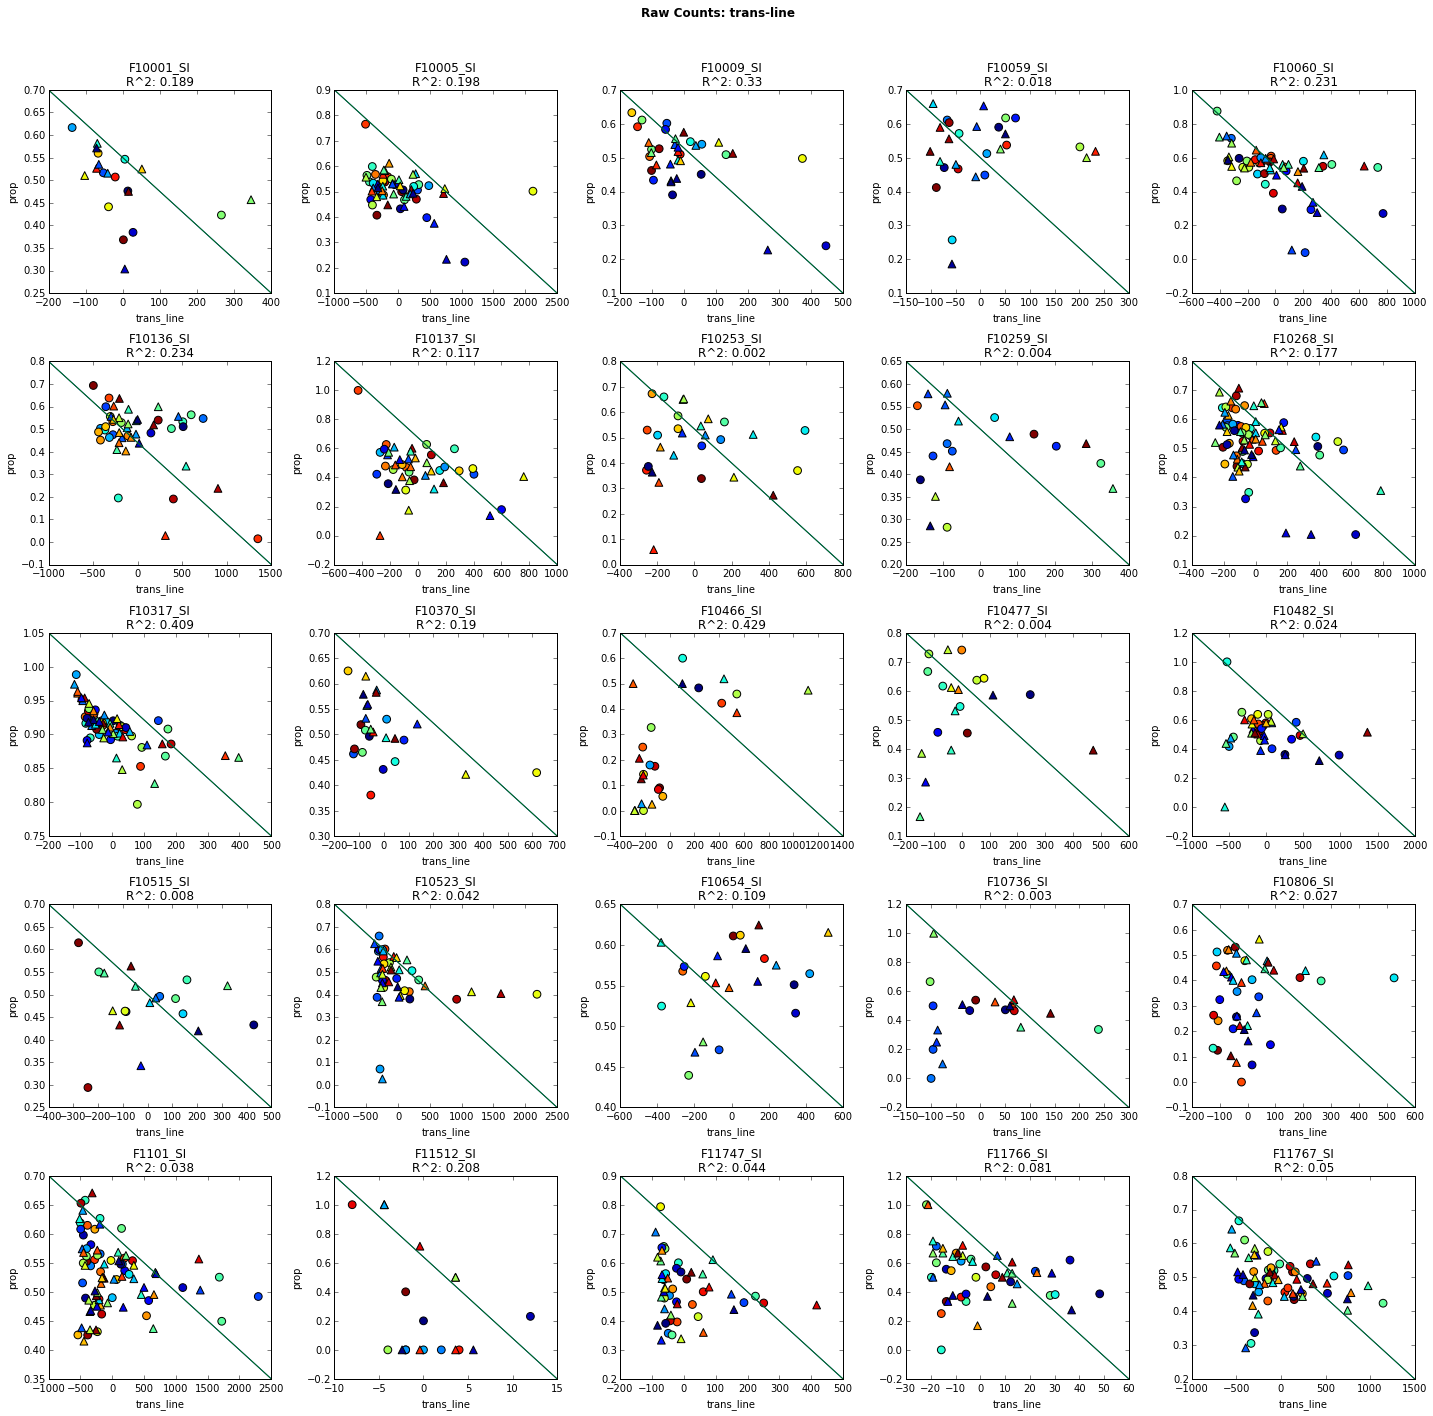

In [29]:
# Plot the trans-line effects x proportion by fusion
fig = scatPltPanel(marenRawCounts, line='sum_line', tester='sum_tester', x='trans_line', cmap=CMAP, panel_title='Raw Counts: trans-line', diag='neg')
plt.tight_layout(rect=[0, 0, 1, .95])

We can then look at different effects for specific functions. 

### F10005_SI
This fusion had a strong linear relationship between *cis*-effects and proportion of line specific reads.

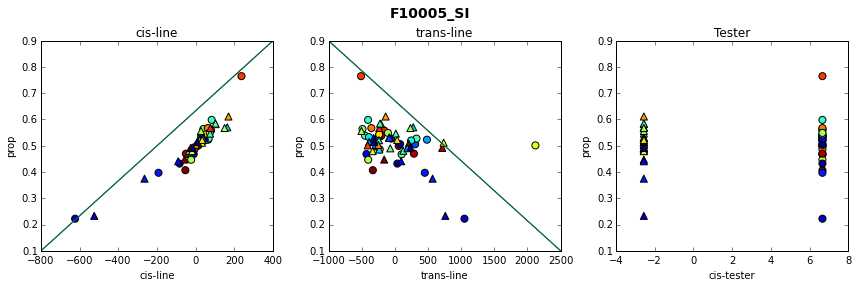

In [30]:
# Plot F10005_SI
FUSION='F10005_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

plt.tight_layout(rect=[0, 0, 1, .95])

### F10317_SI
This fusion has a weaker cis-line effects but trans-line effects look more linear.

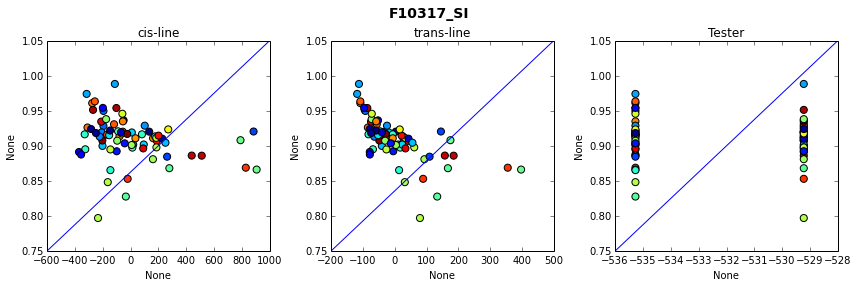

In [187]:
# Plot F10317_SI
FUSION='F10317_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

plt.tight_layout(rect=[0, 0, 1, .95])

### F10482_SI
This fusion has a weaker cis-line effects but trans-line effects look more linear.

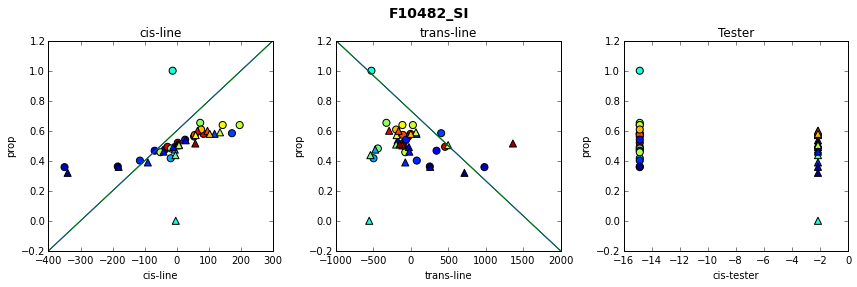

In [32]:
# Plot F10482_SI
FUSION='F10482_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

plt.tight_layout(rect=[0, 0, 1, .95])

## Mean Centered Counts
To verify everything is work, I am going to run mean centered counts through and see if I get similar results. Mean centering the raw counts will allow $\mu = 0$ and I can effectively ignore it. For each fusion_id I take the mean of all the raw counts (line and tester), then subtract this mean value from each count.

This had no affect on the results.

In [36]:
# Mean center
dfMeanCenter = meanCenter(dfGt10, columns=['sum_line', 'sum_tester'], group=['mating_status', 'fusion_id'])

In [37]:
# Calculate Maren TIG equations by mating status and exonic region for mean centered data.
marenMeanCenter = marenEq(dfMeanCenter, Eii='mean_center_sum_line', Eti='mean_center_sum_tester', group=['mating_status', 'fusion_id'])
marenMeanCenter['mag_cis'] = abs(marenMeanCenter['cis_line'])
marenPrintTable(marenMeanCenter, line='mean_center_sum_line', tester='mean_center_sum_tester')

,,,flag_AI_combined,sum_both,mean_center_sum_line,mean_center_sum_tester,cis_line,cis_tester,trans_line,trans_tester,mean_apn
line,mating_status,fusion_id,,,,,,,,,
r101,M,F10005_SI,0,1274,-198.733333,-220.733333,28.666667,6.666667,-448.133333,-6.666667,29.523922
r280,M,F10005_SI,0,1208,-227.733333,-210.733333,-10.333333,6.666667,-428.133333,-6.666667,27.917307
r315,M,F10005_SI,0,1231,-116.733333,-135.733333,25.666667,6.666667,-278.133333,-6.666667,31.867690
r324,M,F10005_SI,1,2554,-4.733333,-77.733333,79.666667,6.666667,-162.133333,-6.666667,60.087419
r335,M,F10005_SI,0,1339,-138.733333,-136.733333,4.666667,6.666667,-280.133333,-6.666667,33.474306
r340,M,F10005_SI,1,1897,-21.733333,-251.733333,236.666667,6.666667,-510.133333,-6.666667,44.059067
r357,M,F10005_SI,1,2797,4.266667,54.266667,-43.333333,6.666667,101.866667,-6.666667,67.345540
r358,M,F10005_SI,0,1494,-168.733333,-191.733333,29.666667,6.666667,-390.133333,-6.666667,34.797401
r365,M,F10005_SI,0,2313,31.266667,32.266667,5.666667,6.666667,57.866667,-6.666667,58.291790


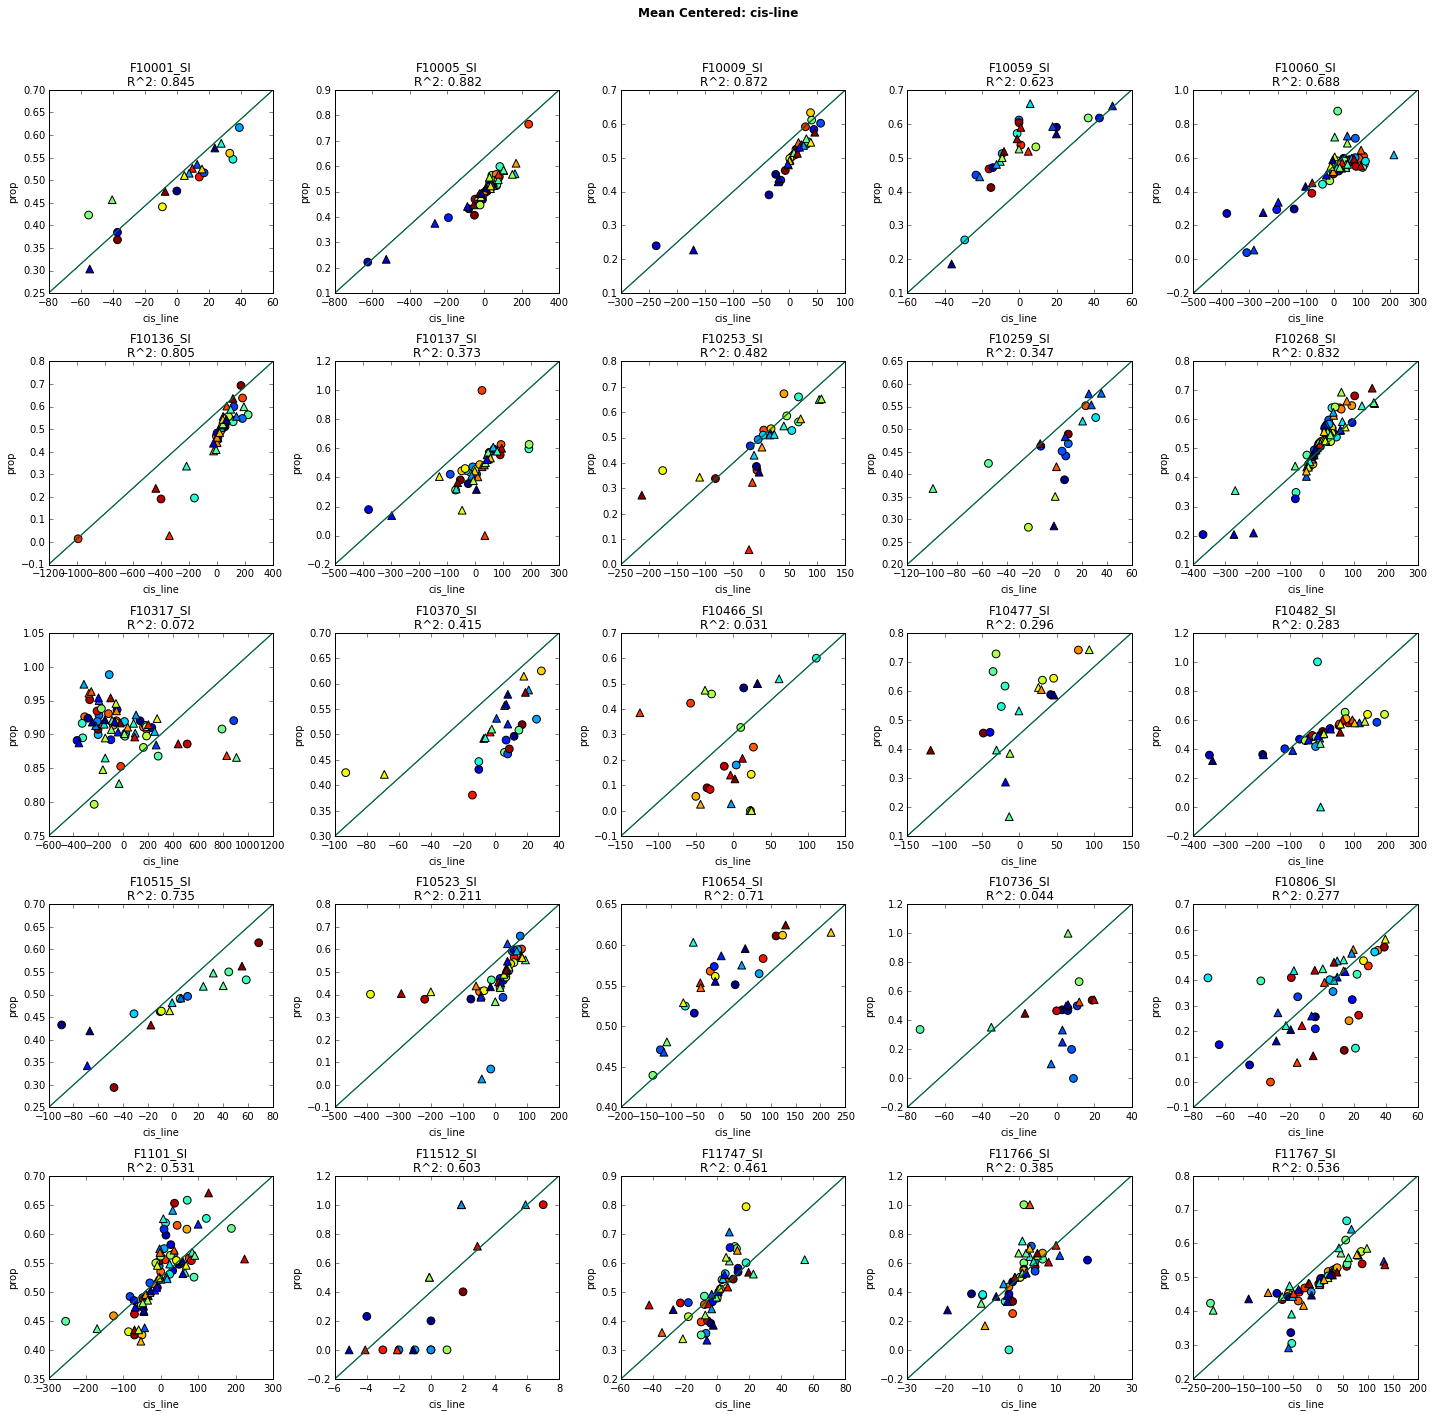

In [39]:
# Plot the cis-line effects x proportion by fusion
fig = scatPltPanel(marenMeanCenter, line='sum_line', tester='sum_tester', x='cis_line', cmap=CMAP, panel_title='Mean Centered: cis-line')
plt.tight_layout(rect=[0, 0, 1, .95])

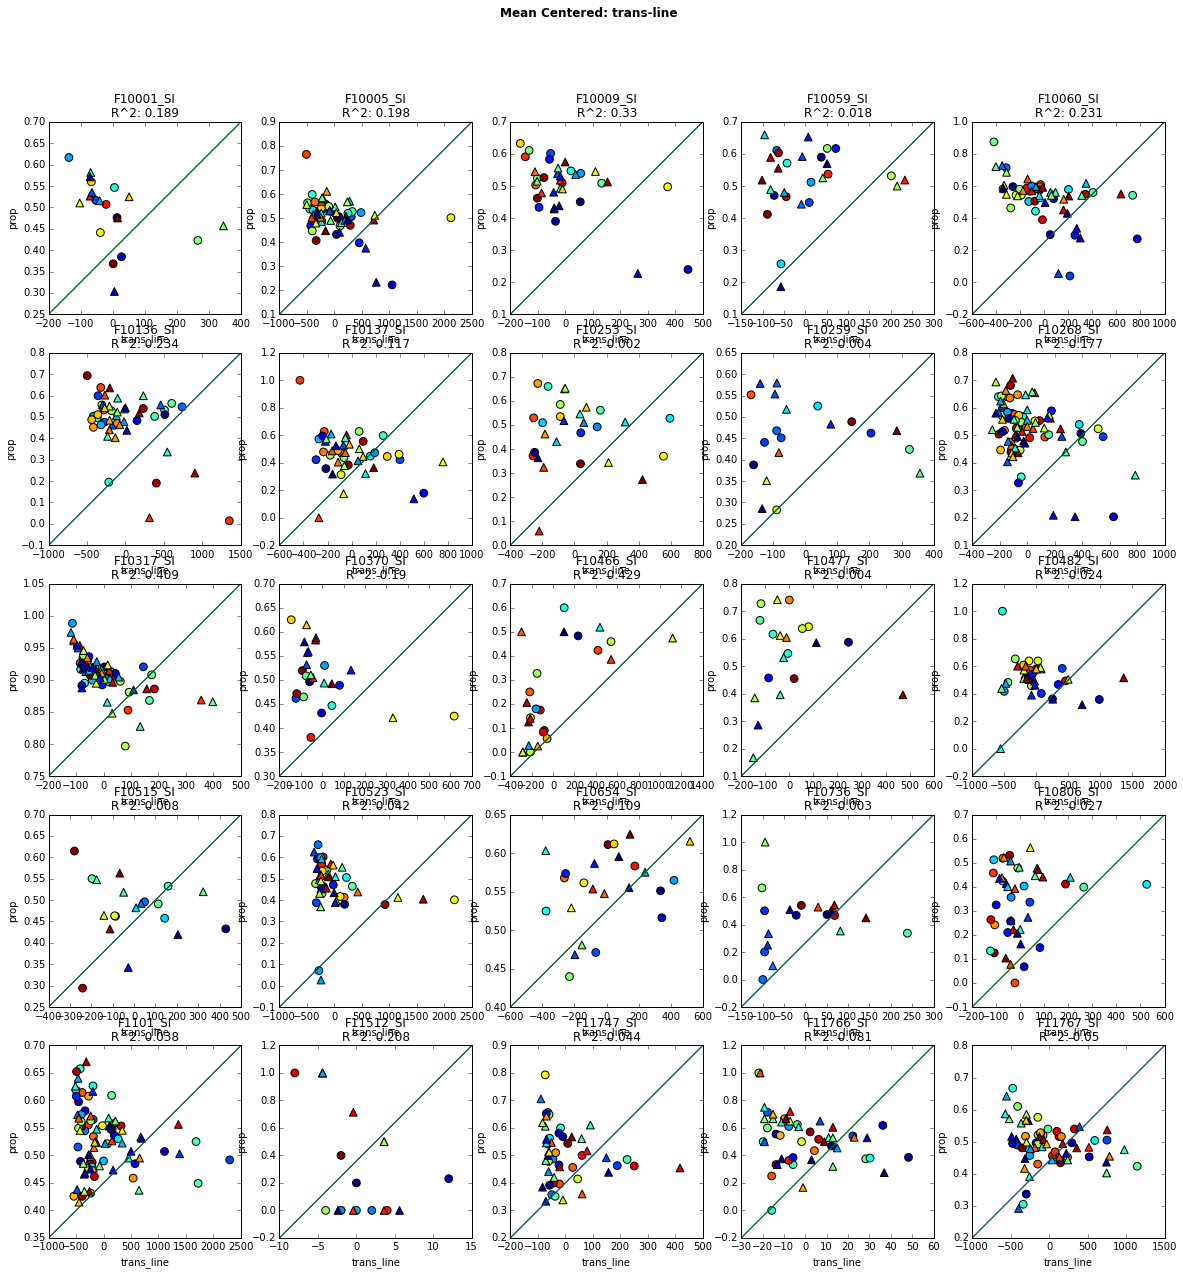

In [40]:
# Plot the cis-line effects x proportion by fusion
fig = scatPltPanel(marenMeanCenter, line='sum_line', tester='sum_tester', x='trans_line', cmap=CMAP, panel_title='Mean Centered: trans-line')